In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.__version__)
# from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

2024-03-28 19:54:02.566747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 19:54:02.569065: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 19:54:02.600967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 19:54:03.197892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [3]:
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")
            
def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["acc"],label='train accuracy')
    plt.plot(history["val_acc"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show

def show_progress_1_2(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["accuracy"],label='train accuracy') # изменил acc на accuracy
    plt.plot(history["val_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()


Описание классов `CIFAR10`

|Label|Description|
|---|---|
|0|airplane|
|1|automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|

Сохрание обученной модели на диске. Пока в нем нет смысла. Отключено

# Загрузка данных.
Разбиение на **2** категории. Самолеты и автомобили

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

category_A = 0
category_B = 1


train_labels = train_labels.flatten()
test_labels = test_labels.flatten()


train_mask = np.logical_or(train_labels == category_A, train_labels == category_B)
test_mask = np.logical_or(test_labels == category_A, test_labels == category_B)

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]

test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

train_images = train_images / 255.0 # Нормализация
test_images = test_images / 255.0


train_images = train_images.reshape(train_images.shape[0], 32, 32, 3) # Изобрадения 32*32 и 3 канала (RGB)
test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)

# Описание архитектуры моделей

## Модель 1

Сверточные слои:
- 3 слоя Conv2D с паддингом 'same', размером ядра 2x2 и функцией активации ReLU.
Пулинг слои:
- 3 слоя MaxPooling2D с размером пула 2x2.
Полносвязные слои:
- 2 полносвязных слоя с функцией активации tanh и softmax.

## Модель 2

Сверточные слои:
- 3 слоя Conv2D с паддингом 'same', размером ядра 2x2 и функцией активации LeakyReLU(alpha=0.1).
Пулинг слои:
- 3 слоя MaxPooling2D с размером пула 2x2.
Полносвязные слои:
- 2 полносвязных слоя с функцией активации LeakyReLU(alpha=0.1) и softmax.

## Модель 3

Сверточные слои:
- 4 слоя Conv2D с паддингом 'same', размером ядра 3x3 и функцией активации ReLU.
Пулинг слои:
- 2 слоя MaxPooling2D с размером пула 2x2.
Полносвязные слои:
- 2 полносвязных слоя с функцией активации ReLU.
Dropout:
- Два слоя Dropout с вероятностью отключения 0.5.


In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 8, kernel_size = 2, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 64, activation = 'tanh', kernel_initializer = 'glorot_uniform'),

  tf.keras.layers.Dense(10, activation = 'softmax')
])                 

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation=LeakyReLU(alpha=0.1), input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation=LeakyReLU(alpha=0.1)),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=8, kernel_size=2, padding='same', activation=LeakyReLU(alpha=0.1)),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation=LeakyReLU(alpha=0.1), kernel_initializer='glorot_uniform'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Компиляция моделей

## Модель 1
- **Оптимизатор**: Adam

## Модель 2
- **Оптимизатор**: SGD (стохастический градиентный спуск)

## Модель 3
- **Оптимизатор**: Adam


In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model1.compile(optimizer='sgd', 
               loss=keras.losses.SparseCategoricalCrossentropy(), # То же самое
               metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,906 (46.51 KB)

 Trainable params: 11,906 (46.51 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,906 (46.51 KB)

 Trainable params: 11,906 (46.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,754 (9.12 MB)

 Trainable params: 2,391,754 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение моделей
- Эпох $5$  
- Размер пачки $64$
- На валидацию выделено $20 \%$

In [10]:
history = model.fit(train_images, train_labels,
                    epochs=5,
                    validation_split=0.2,
                    batch_size=64)
                    # callbacks=[checkpoint_callback])

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.5527 - loss: 1.0359 - val_acc: 0.7930 - val_loss: 0.4624
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7981 - loss: 0.4516 - val_acc: 0.8310 - val_loss: 0.3887
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.8386 - loss: 0.3789 - val_acc: 0.8470 - val_loss: 0.3482
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.8504 - loss: 0.3447 - val_acc: 0.8485 - val_loss: 0.3561
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.8653 - loss: 0.3277 - val_acc: 0.8720 - val_loss: 0.3019


In [11]:
history1 = model1.fit(train_images, train_labels,
                    epochs=5,
                    validation_split=0.2,
                    batch_size=64)
                    # callbacks=[checkpoint_callback])

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4732 - loss: 1.3821 - val_accuracy: 0.6095 - val_loss: 0.6708
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5911 - loss: 0.6737 - val_accuracy: 0.6275 - val_loss: 0.6492
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6121 - loss: 0.6584 - val_accuracy: 0.6815 - val_loss: 0.6281
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6432 - loss: 0.6388 - val_accuracy: 0.6880 - val_loss: 0.6094
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6721 - loss: 0.6074 - val_accuracy: 0.7290 - val_loss: 0.5603


In [12]:
history2 = model2.fit(train_images, train_labels,
                    epochs=5,
                    validation_split=0.2,
                    batch_size=64)
                    # callbacks=[checkpoint_callback])

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.6248 - loss: 0.8118 - val_accuracy: 0.8725 - val_loss: 0.3177
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.8593 - loss: 0.3505 - val_accuracy: 0.9140 - val_loss: 0.2040
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.9141 - loss: 0.2140 - val_accuracy: 0.9355 - val_loss: 0.1814
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9384 - loss: 0.1598 - val_accuracy: 0.9480 - val_loss: 0.1411
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.9444 - loss: 0.1433 - val_accuracy: 0.9525 - val_loss: 0.1255


# Результаты

In [13]:
loss, acc = model.evaluate(test_images, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8637 - loss: 0.3072


In [14]:
print(f"Accuracy of restored model {acc*100 :.2f}%")

Accuracy of restored model 87.60%


In [15]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

report = classification_report(test_labels, predicted_labels)

print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1000
           1       0.88      0.87      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [16]:
loss, acc = model1.evaluate(test_images, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7271 - loss: 0.5458


In [17]:
print(f"Accuracy of restored model {acc*100 :.2f}%")


Accuracy of restored model 73.05%


In [18]:
predictions = model1.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

report = classification_report(test_labels, predicted_labels)

print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      1000
           1       0.78      0.64      0.70      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000



In [19]:
loss, acc = model2.evaluate(test_images, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9658 - loss: 0.1041


In [20]:
print(f"Accuracy of restored model {acc*100 :.2f}%")


Accuracy of restored model 95.55%


In [21]:
predictions = model2.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

report = classification_report(test_labels, predicted_labels)

print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1000
           1       0.95      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



# Графики

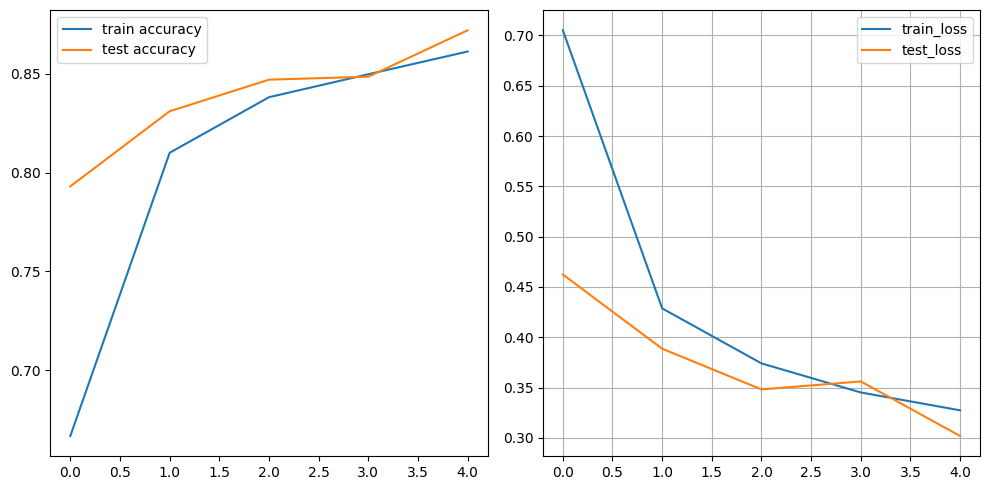

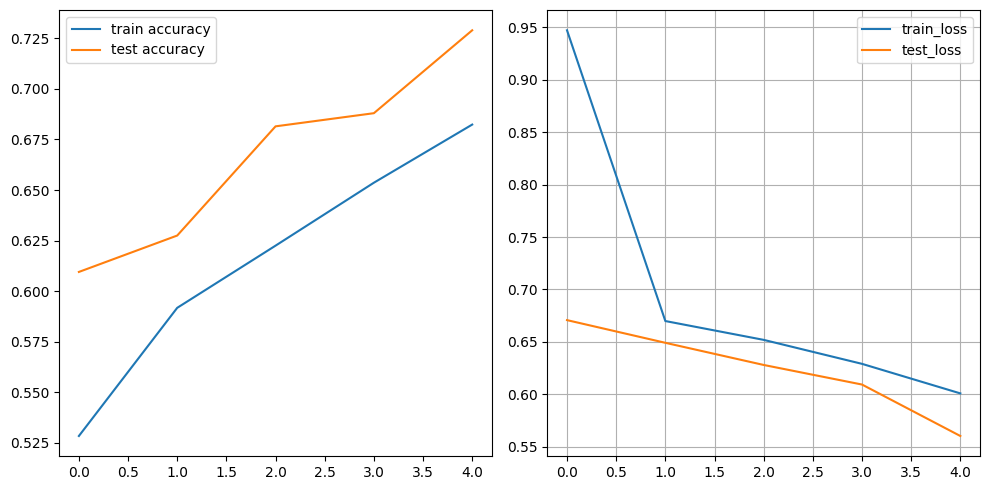

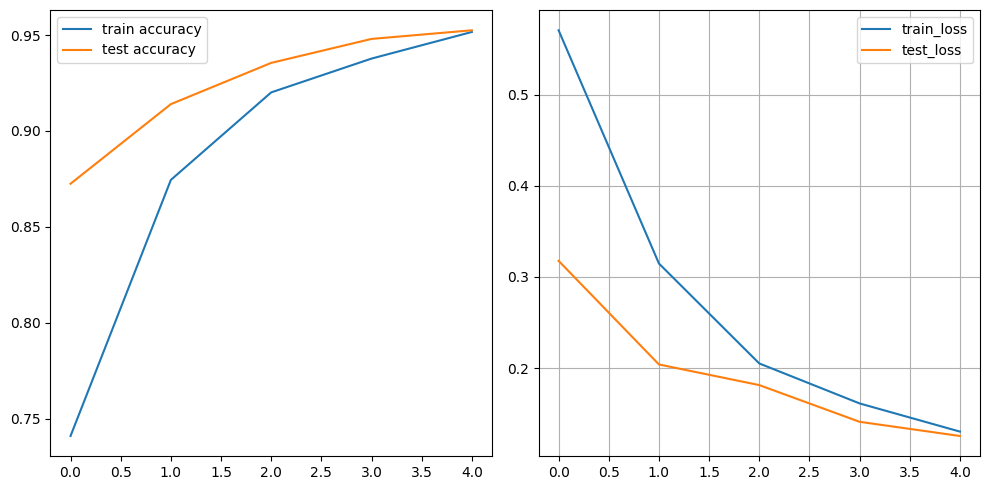

In [22]:
show_progress(history.history)
show_progress_1_2(history1.history)
show_progress_1_2(history2.history)

# Выводы
Лучше всего для поставленной задачи модель 3